In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from wave_propagation import *

# 3. Wave propagation
_Kevin Vonk, s1706896, Mar - Apr 2020_

### Section 1: A square barrier

#### a)

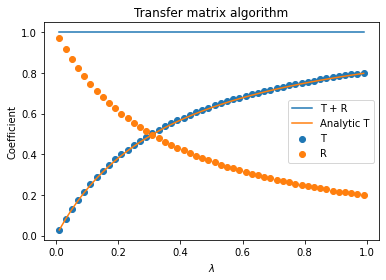

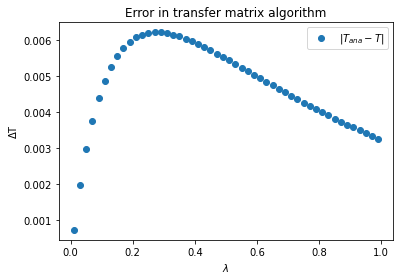

In [2]:
pot = Potential(-0.5, 0.5, 100, expr = lambda y: 1)
lambda_ = np.linspace(0.01, 0.99, 50)

T = []
R = []

for l in lambda_:
    tf = TransferMatrix(pot, l)
    T.append(tf.transmission())
    R.append(tf.reflection())
    
plt.scatter(lambda_, T, label="T")
plt.scatter(lambda_, R, label="R")
plt.plot(lambda_, [i + j for i, j in zip(T, R)], label="T + R")
plt.plot(lambda_, T_ana(lambda_), label="Analytic T")
plt.xlabel(r"$\lambda$")
plt.ylabel("Coefficient")
plt.title("Transfer matrix algorithm")
plt.legend()

plt.figure()
plt.scatter(lambda_, np.abs(T_ana(lambda_) - T), label=r"$| T_{ana} - T |$")
plt.xlabel(r"$\lambda$")
plt.ylabel(r"$\Delta$T")
plt.legend()
plt.title("Error in transfer matrix algorithm");

From the first plot we can see that the analytic and computed transmissions are quite close together. The reflection and transmission coefficients sum to 1 as expected.

Looking at the error plot, we see that the accuracy is roughly $10^{-2}$.

#### b)

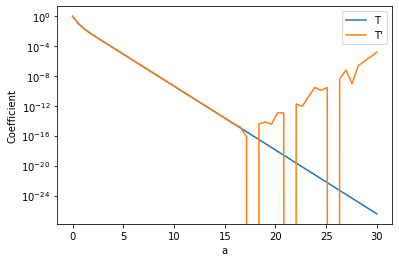

In [3]:
lambda_ = 0.01
A = np.linspace(0, 30, 50)

T = []
Tp = []

for a in A:
    pot = Potential(-0.5*a, 0.5*a, 100, expr = lambda y: 1)
    tf = TransferMatrix(pot, lambda_)
    
    T.append(tf.transmission())
    Tp.append(tf.transmission(dir="left"))
    
plt.semilogy(A, T, label="T")
plt.semilogy(A, Tp, label="T'")
plt.xlabel("a")
plt.ylabel("Coefficient")
plt.legend();

As we can see from the plot above, a numerical instability occurs when calculating T' when the barrier thickness a becomes too large. If the numeric solution were to be accurate, one would expect T and T' to be identical. This is because the properties of a medium are independent of the directionality of the incoming wave in this case.

The reason that this numerical instability occurs has to do with the way a computer stores numbers. Decimal numbers are stored as floats: floating point numbers. On a 64-bit machine, 52 bits are used to store the fraction, 11 bits for the exponent and 1 bit for the sign, resulting in the following expression for the number:

\begin{equation}
    n = (-1)^{\text{sign}} * \text{fraction} * 10^{\text{exponent}}
\end{equation}
(The actual number conversion is slightly different from the representation here given IEEE 754, but that is beyond the scope of this report.)

Because we have a finite amount of bits to represent every number, we cannot represent every number exactly. This results in a grid or a number line of values we can actually represent. For example, say that a float can represent every $0,1n$ steps, where $n \in \mathbb{Z}$. If we want to have the number $0,17$ represented in this system, it must be rounded up to $0,2$ in order to be stored.

This problem compounds itself when doing arithmatic upon two floats. If the exponents are similar in their orders of magnitude, the accuracy lost due to floating point rounding errors is limited. However, if there is too much variation in the exponents, the largest one will take precedence. In order for arithmatic to occur, the float with the smaller exponent must realign itself onto the grid of the larger exponent. In the worst case, the closest point to which the float can align is zero, and thus the smaller float is lost completely in the arithmatic operation.

This problem then is what we see in the figure above. The coefficients become smaller and smaller, up to a point where there simply aren't enough bits of accuracy to complete the arithmatic "correctly" (floating point math is never really "correct", it is always an approximation). Since we only have 11 bits of exponent accuracy, it is fairly easy to run into this problem.

#### c)

As a sanity check, let us first compare the results of 1a) to our scattering matrix result. If everything has gone well, the results should be the same.

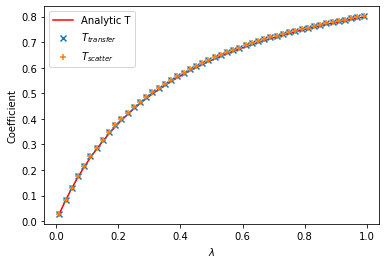

In [4]:
pot = Potential(-0.5, 0.5, 100, expr = lambda y: 1)
lambda_ = np.linspace(0.01, 0.99, 50)

Tt = []
Ts = []

for l in lambda_:
    tm = TransferMatrix(pot, l)
    sm = ScatterMatrix(pot, l)
    Tt.append(tm.transmission())
    Ts.append(sm.transmission())

plt.plot(lambda_, T_ana(lambda_), "-r", label="Analytic T", zorder=-100)
plt.scatter(lambda_, Tt, label=r"$T_{transfer}$", marker="x")
plt.scatter(lambda_, Ts, label=r"$T_{scatter}$", marker="+")
plt.xlabel(r"$\lambda$")
plt.ylabel("Coefficient")
plt.legend();

From the figure above we can deduce that the results of the scattering matrix line up with the results of both the transfer matrix algorithm and the analytic expression. Now then, let us redo the experiment of 1b) with the scattering matrix.

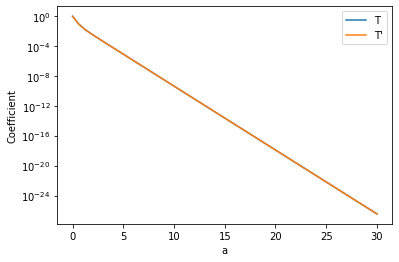

In [5]:
lambda_ = 0.01
A = np.linspace(0, 30, 50)

T = []
Tp = []

for a in A:
    pot = Potential(-0.5*a, 0.5*a, 100, expr = lambda y: 1)
    sm = ScatterMatrix(pot, lambda_)
    
    T.append(sm.transmission())
    Tp.append(sm.transmission(dir="left"))
    
plt.semilogy(A, T, label="T")
plt.semilogy(A, Tp, label="T'")
plt.xlabel("a")
plt.ylabel("Coefficient")
plt.legend();

Using the scattering matrix, the numeric stability is preserved and the transmission coefficient from either direction is identical. The reason that we do not see the floating point rounding errors in $T'$ here, is simply because propagation from the left and from the right are treated as equal, instead of forced to originate from one direction.

#### d)

Taking the code from 1b) and setting $\lambda = 0,5$:

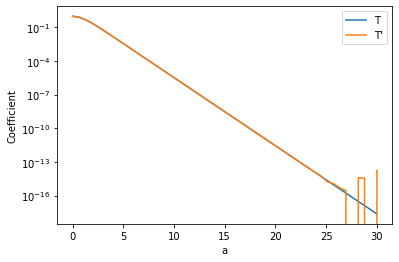

In [6]:
lambda_ = 0.5
A = np.linspace(0, 30, 50)

T = []
Tp = []

for a in A:
    pot = Potential(-0.5*a, 0.5*a, 100, expr = lambda y: 1)
    tf = TransferMatrix(pot, lambda_)
    
    T.append(tf.transmission())
    Tp.append(tf.transmission(dir="left"))
    
plt.semilogy(A, T, label="T")
plt.semilogy(A, Tp, label="T'")
plt.xlabel("a")
plt.ylabel("Coefficient")
plt.legend();

Whilst not as pronounced as in the case of 1b), there still exists a numerical instability when using the transfer matrix for increased barrier thickness. The reason for the instability occuring at a larger thickness compared to 1b) is because there is more energy for the wave to propagate through the barrier, meaning that the decrease in the transmission coefficient is less drastic. However, once we near the region where we do not have enough bits of accuracy, we start seeing the numerical instability yet again.

All in all, the scattering matrix algorithm seems like the more stable algorithm. Furthermore, it is not less accurate than the transfer matrix algorithm in areas where the numerical stability of the transfer matrix is a non-issue. Additionally, the numerical complexity O is the same order for both algorithms. Hence, I recommend the scattering matrix algorithm over the transfer matrix algorithm.

### Section 2: A distorted barrier
#### a)

In order to determine the minimal amount of grid points required to describe the transmission coefficient with the requested accuracy, I will iterate over a large amount of grid points. We can assume the transmission coefficient be fully converged when the amount of grid points nears infinity. Thus, a large amount of grid points already consitutes a "fair" accuracy.

In this instance, we calculated the transmission coefficient for a range between 2 and 501 grid points. The convergence of $10^{-5}$ will be compared to the most accurate grid (with 501 points). From the results below we can see that we need 86 grid points to obtain the required accuracy. Discarding digits not within the accuracy window, we obtain $T = 0,71036$, which is the same for 86 and 501 grid points. Thus, 86 grid points is accuracte enough.

At y_grid = 86 the transmission T = 0.7103649900530405 has converged to within 1e-05
The most accurate grid (y_grid = 501) saw transmission T = 0.710363726747062


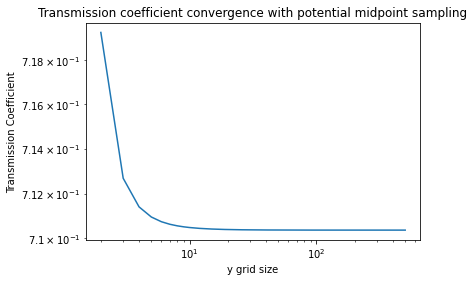

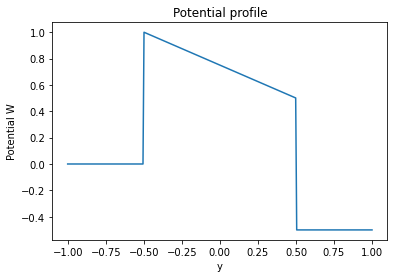

In [7]:
V1 = 1
a = 1
dV = 0.5
lambda_ = 0.5
epsilon = dV / a
conv = 10**-5

start = 2
end = start + 500

T = []

for grid in range(start, end):
    pot = Potential(-0.5*a, 0.5*a, grid, \
                   expr = lambda y: V1 - epsilon * (y + 0.5*a), \
                   outside_range = (lambda _: 0, lambda _: -epsilon * a))
    sm = ScatterMatrix(pot, lambda_)
    sm.midpoint = True
    
    T.append(sm.transmission())
    
conv_keys = [i for i, _ in enumerate(T[:-1]) if int(round(T[i] / conv)) == int(round(T[-1] / conv))]
print(f"At y_grid = {conv_keys[0] + start} the transmission T = {T[conv_keys[0]]} has converged to within {conv}")
print(f"The most accurate grid (y_grid = {len(T) - 1 + start}) saw transmission T = {T[-1]}")

plt.loglog(range(start, end), T)
plt.xlabel("y grid size")
plt.ylabel("Transmission Coefficient")
plt.title("Transmission coefficient convergence with potential midpoint sampling")

plt.figure()
plt.plot(np.linspace(-1, 1, 300), [pot[i] for i in np.linspace(-1, 1, 300)])
plt.xlabel("y")
plt.ylabel("Potential W")
plt.title("Potential profile");

#### b)
The code below is copy-pasted from 2a), but now not taking midpoints when sampling the potential. I again limited the code to a maximum of 501 grid points to ensure the code runs quickly enough. From the results below we can note a number of things:
 - The required accuracy is not reached with 501 grid points. Discarding the decimals smaller than $10^{-5}$ still results in two different values for the transmission coefficient.
 - The found most accurate grid is very close to the set upper boundary. This again calls into question whether this result is valid.
 - The found transmission value is higher than that found in 2a). In the converging process, the transmission coefficient decreases until converged. Since this result is higher, it is still less converged than the result of 2a).
 - The convergence is slower compared to 2a), as seen when comparing the plots.
 
From this we can conclude that using midpoint sampling of the potential is more accurate and efficient. It provides a transmission coefficient closer to the actual value with less data points to iterate over.

At y_grid = 498 the transmission T = 0.7112133973171466 has converged to within 1e-05
The most accurate grid (y_grid = 501) saw transmission T = 0.7112082999133984


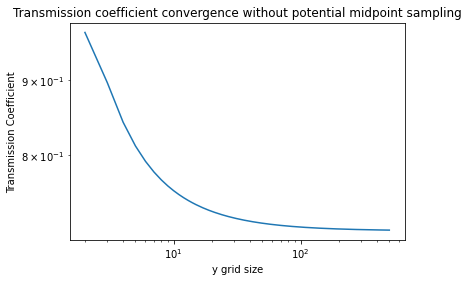

In [8]:
T = []

for grid in range(start, end):
    pot = Potential(-0.5*a, 0.5*a, grid, \
                   expr = lambda y: V1 - epsilon * (y + 0.5*a), \
                   outside_range = (lambda _: 0, lambda _: -epsilon * a))
    sm = ScatterMatrix(pot, lambda_)
    sm.midpoint = False
    
    T.append(sm.transmission())
    
conv_keys = [i for i, _ in enumerate(T[:-1]) if int(round(T[i] / conv)) == int(round(T[-1] / conv))]
print(f"At y_grid = {conv_keys[0] + start} the transmission T = {T[conv_keys[0]]} has converged to within {conv}")
print(f"The most accurate grid (y_grid = {len(T) - 1 + start}) saw transmission T = {T[-1]}")

plt.loglog(range(start, end), T)
plt.xlabel("y grid size")
plt.ylabel("Transmission Coefficient")
plt.title("Transmission coefficient convergence without potential midpoint sampling");

#### c)
The plot of the analytic transmission coefficient for the square potential and the computed transmission coefficient for the triangularly distorted potential is found below. From this plot we gather that the transmission for the distorted barrier is higher than that of the square barrier. This is especially the case for lower energies, as for higher energies the transmission coefficient will converge towards 1.

There are two main reasons the transmission for the distorted potential is higher:
 - The energy on the right side of the barrier is lower than that on the left side. A wave incoming from the left side will have an easier time overcoming the barrier because of the potential energy gain having transmitted through to the other side. This is not the case for the square barrier.
 - The average potential for the distorted barrier is lower than that of the square barrier. This makes transmission easier because a lower barrier means higher transmission.

The profile of the potential itself will also influence the transmission. Most notably a higher potential means a faster decay of transmission given increasing barrier thickness. In the case of the distorted potential, the decreasing potential profile means that the transmission coefficient decays less quickly when an incident wave passes through. This however is harder to derive from the figure below.

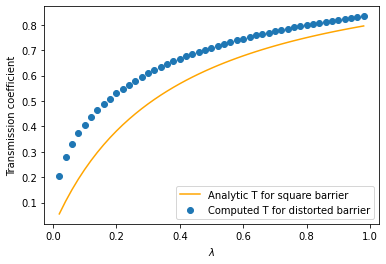

In [9]:
lambda_ = np.linspace(0, V1, 50, endpoint=False)[1:]
grid = 86

T = []

for l in lambda_:
    pot = Potential(-0.5*a, 0.5*a, grid, \
                   expr = lambda y: V1 - epsilon * (y + 0.5*a), \
                   outside_range = (lambda _: 0, lambda _: -epsilon * a))
    sm = ScatterMatrix(pot, l)
    sm.midpoint = True
    
    T.append(sm.transmission())
    
plt.scatter(lambda_, T, label="Computed T for distorted barrier")
plt.plot(lambda_, T_ana(lambda_), label="Analytic T for square barrier", color="orange")
plt.xlabel(r"$\lambda$")
plt.ylabel("Transmission coefficient")
plt.legend();

### Section 3: The WKB approximation
#### a)
Both a plot of $T(\lambda)$ and $T_{WKB}(\lambda)$ and a plot of the difference between the two can be found below.

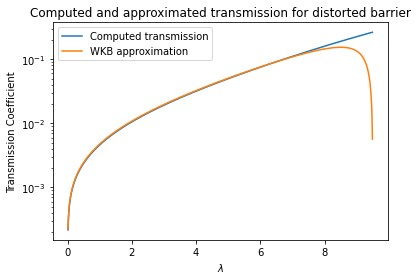

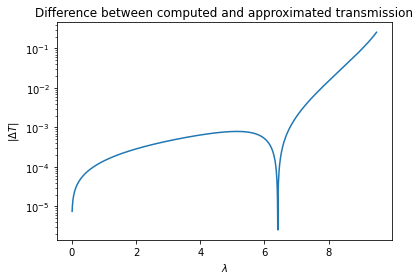

In [14]:
V1 = 10
a = 1
dV = 0.5
epsilon = dV / a

lambda_ = np.linspace(0.01, V1-dV, 1000, endpoint=False)

T = []
Twkb = []

for l in lambda_:
    pot = Potential(-0.5*a, 0.5*a, 100, \
                    expr = lambda y: V1 - epsilon * (y + 0.5*a), \
                    outside_range = (lambda _: 0, lambda _: -epsilon * a))
    sm = ScatterMatrix(pot, l)
    sm.midpoint = True
    
    T.append(sm.transmission())
    Twkb.append(sm.T_wkb(lambda lam: (16*lam*(V1-dV-lam))/V1**2))

plt.semilogy(lambda_, T, label="Computed transmission")
plt.semilogy(lambda_, Twkb, label="WKB approximation")
plt.xlabel(r"$\lambda$")
plt.ylabel("Transmission Coefficient")
plt.title("Computed and approximated transmission for distorted barrier")
plt.legend()

plt.figure()
plt.semilogy(lambda_, np.abs(np.array(T)-np.array(Twkb)))
plt.xlabel(r"$\lambda$")
plt.ylabel(r"$|\Delta T|$")
plt.title("Difference between computed and approximated transmission");

From these two plots we can gather that for low energies $\lambda$, the WKB approximation is relatively accurate. Up to around $\lambda \approx 6$, the accuracy in the approximated transmission coefficient is $\leq 10^{-3}$. For higher energies however, the WKB approximation starts to fail. We see that around $\lambda \approx 9$ the approximated transmission coefficient starts to decrease rapidly. We would however expect that the transmission reaches 1 as the energy goes to infinity. Thus, for higher energies the computed transmission coefficient seems to hold on.

#### b)
Modifying the code from 3a) slightly, we obtain the results as found below.

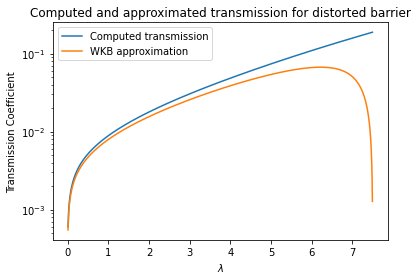

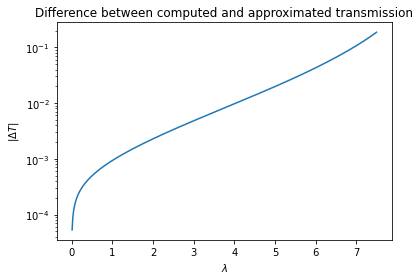

In [15]:
V1 = 10
a = 1
dV = 2.5
epsilon = dV / a

lambda_ = np.linspace(0.01, V1-dV, 1000, endpoint=False)

T = []
Twkb = []

for l in lambda_:
    pot = Potential(-0.5*a, 0.5*a, 100, \
                    expr = lambda y: V1 - epsilon * (y + 0.5*a), \
                    outside_range = (lambda _: 0, lambda _: -epsilon * a))
    sm = ScatterMatrix(pot, l)
    sm.midpoint = True
    
    T.append(sm.transmission())
    Twkb.append(sm.T_wkb(lambda lam: (16*lam*(V1-dV-lam))/V1**2))

plt.semilogy(lambda_, T, label="Computed transmission")
plt.semilogy(lambda_, Twkb, label="WKB approximation")
plt.xlabel(r"$\lambda$")
plt.ylabel("Transmission Coefficient")
plt.title("Computed and approximated transmission for distorted barrier")
plt.legend()

plt.figure()
plt.semilogy(lambda_, np.abs(np.array(T)-np.array(Twkb)))
plt.xlabel(r"$\lambda$")
plt.ylabel(r"$|\Delta T|$")
plt.title("Difference between computed and approximated transmission");

Because of the increased change in the barrier profile, the accuracy of the WKB approximation has taken an overall hit. For small energies $\lambda \leq 1$ the accuracy is still reasonable ($\leq 10^{-3}$). For larger energies however, the approximation starts deviating more and more from the expected value.
The WKB approximation is functions if an ballpark estimate for the transmission coefficient needs to be determined. With this barrier profile then, it still can prove useful.

#### c)
We again modify the code to obtain the results found below.

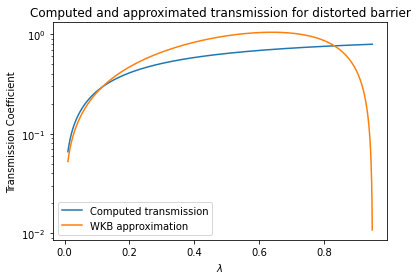

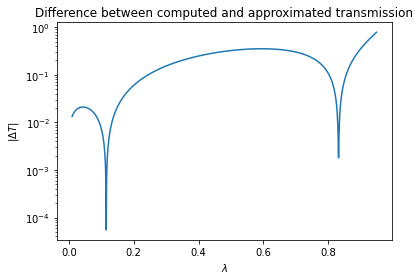

In [16]:
V1 = 1
a = 1
dV = 0.05
epsilon = dV / a

lambda_ = np.linspace(0.01, V1-dV, 1000, endpoint=False)

T = []
Twkb = []

for l in lambda_:
    pot = Potential(-0.5*a, 0.5*a, 100, \
                    expr = lambda y: V1 - epsilon * (y + 0.5*a), \
                    outside_range = (lambda _: 0, lambda _: -epsilon * a))
    sm = ScatterMatrix(pot, l)
    sm.midpoint = True
    
    T.append(sm.transmission())
    Twkb.append(sm.T_wkb(lambda lam: (16*lam*(V1-dV-lam))/V1**2))

plt.semilogy(lambda_, T, label="Computed transmission")
plt.semilogy(lambda_, Twkb, label="WKB approximation")
plt.xlabel(r"$\lambda$")
plt.ylabel("Transmission Coefficient")
plt.title("Computed and approximated transmission for distorted barrier")
plt.legend()

plt.figure()
plt.semilogy(lambda_, np.abs(np.array(T)-np.array(Twkb)))
plt.xlabel(r"$\lambda$")
plt.ylabel(r"$|\Delta T|$")
plt.title("Difference between computed and approximated transmission");

In this case we are dealing with a small barrier which changes slightly in the positional axis. For this scenario the WKB approximation can be considered invalid. The computed transmission curve does not resemble the WKB approximation curve in the slightest, and the two small difference peaks are merely a side effect of the usage of absolute values. The WKB approximation is also unable to provide a ballpark estimate for the transmission coefficient. At best, it would be able to at least give a correct order approximation, but given its extreme inaccuracy I'd recommend not using it at all in this case.

#### d)
From the three experiments found above, we can determine a region for which the WKB approximation is valid. The WKB approximation falls apart when the potential is relatively small or when the energy $\lambda$ becomes too large. The accuracy of the WKB approximation also decreases when the potential (profile) change increases.

Thus, the WKB approximation is valid and most accurate when $\lambda \leq V_1 - \Delta V$, $\Delta V \ll V_1$ and(!) $V_1 \gg 1$.